In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# Data-Driven Bid and Valuation Estimates from Different First-Price Auction Models #
### Author: Ya Shi Zhang | Email: yashi.zhang@nyu.edu ###

In [176]:
data = pd.read_csv('auctiondata.csv')
data.head()

,Experiment,Period,Subject,Value,BidC3_o,Unnamed: 5,BidNC,Market,BidC3,BidC6,Ncont,Size6,Vh,BidC6.1
0,3,5,1,9.21,8.00,.,.,1,8.00,8.50,0,0,30,8.50
1,3,5,2,4.38,4.00,.,.,0,4.00,4.25,0,0,30,4.25
2,3,5,3,28.05,21.05,.,.,0,21.05,22.05,0,0,30,22.05
3,3,5,4,26.44,20.44,.,.,1,20.44,21.44,0,0,30,21.44
4,3,5,5,21.49,18.49,.,.,0,18.49,19.49,0,0,30,19.49


### Risk-Neutral Equilibrium Model for Bid-Prediction ###

##### Theoretical Bids vs. Actual Bids #####

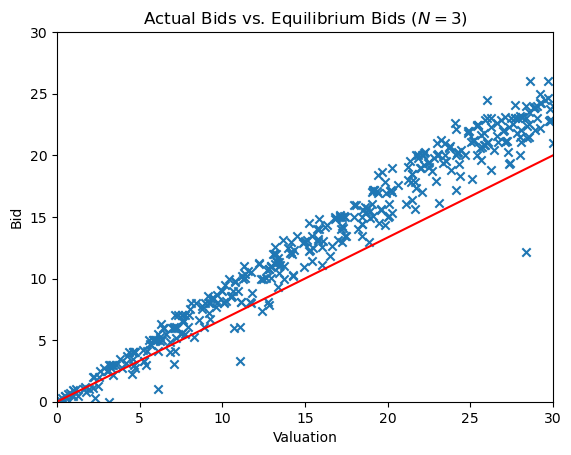

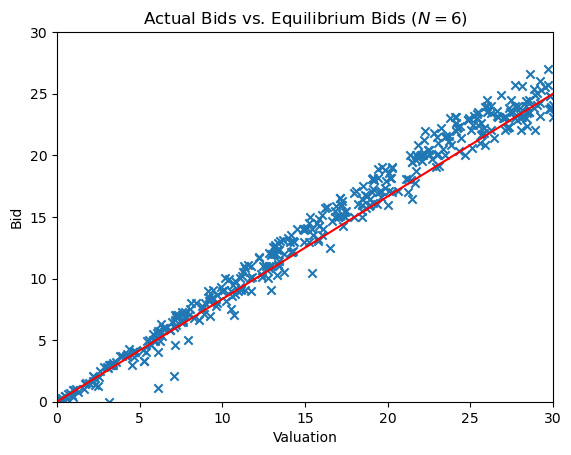

In [177]:
# Plotting N=3
plt.figure()
plt.scatter(data['Value'].values, data['BidC3'].values, marker='x')
plt.plot(np.linspace(0,30,5), (2/3)*np.linspace(0,30,5), 'r')
plt.xlim(0,30)
plt.ylim(0,30)
plt.title('Actual Bids vs. Equilibrium Bids ($N=3$)')
plt.xlabel('Valuation')
plt.ylabel('Bid')
plt.show()

# Plotting N=6
plt.figure()
plt.scatter(data['Value'].values, data['BidC6'].values, marker='x')
plt.plot(np.linspace(0,30,5), (5/6)*np.linspace(0,30,5), 'r')
plt.xlim(0,30)
plt.ylim(0,30)
plt.title('Actual Bids vs. Equilibrium Bids ($N=6$)')
plt.xlabel('Valuation')
plt.ylabel('Bid')
plt.show()

##### Computing the Empirical Cumulative Distribution Function #####

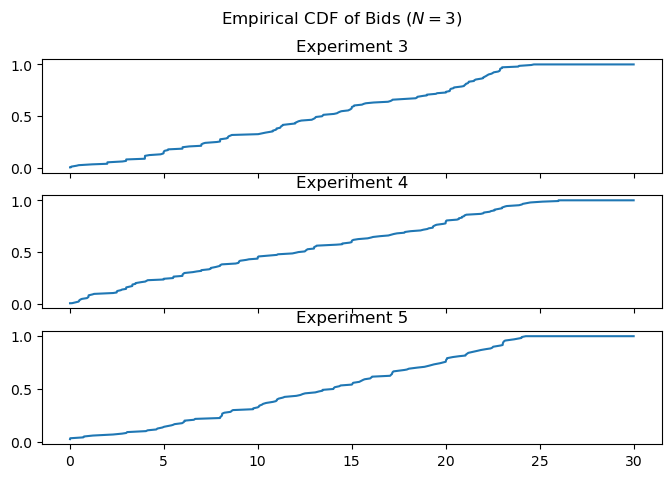

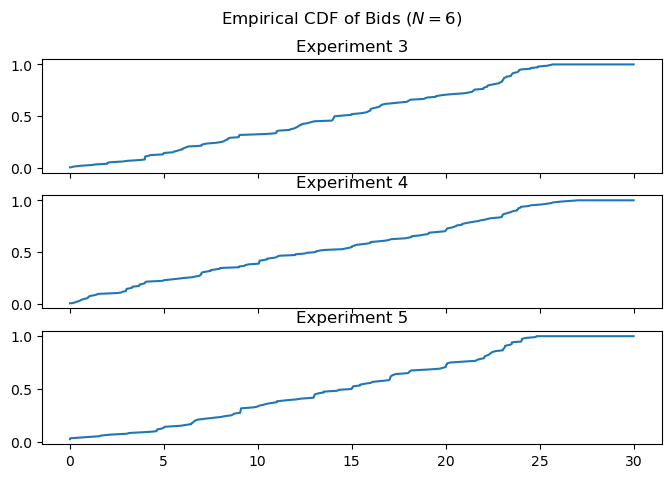

In [178]:
# Given a list of values, returns the empirical distribution of values
def ecdf(bid_data):
    x = np.sort(bid_data)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

# Given a list of bids and input, returns the empirical distribution of bids evaluated at input
def empirical_distribution(bid_data, input):
    x, y = ecdf(bid_data)
    return np.interp(input, x, y)

# Splitting data by experiment number
data_e3 = data[data['Experiment'] == 3]
data_e4 = data[data['Experiment'] == 4]
data_e5 = data[data['Experiment'] == 5]

# For each auction size, plot the empirical CDF of the 3 experiments for N=3
grid = np.linspace(0.01,30,3000)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,5));
ax1.plot(grid, empirical_distribution(data_e3['BidC3'].values, grid),
 label='Experiment 3');
ax1.set_title('Experiment 3');
ax2.plot(grid, empirical_distribution(data_e4['BidC3'].values, grid),
 label='Experiment 4');
ax2.set_title('Experiment 4');
ax3.plot(grid, empirical_distribution(data_e5['BidC3'].values, grid),
 label='Experiment 5');
ax3.set_title('Experiment 5');
fig.suptitle('Empirical CDF of Bids ($N=3$)');

# Now do the same for N=6
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,5));
ax1.plot(grid, empirical_distribution(data_e3['BidC6'].values, grid),
 label='Experiment 3');
ax1.set_title('Experiment 3');
ax2.plot(grid, empirical_distribution(data_e4['BidC6'].values, grid),
 label='Experiment 4');
ax2.set_title('Experiment 4');
ax3.plot(grid, empirical_distribution(data_e5['BidC6'].values, grid),
 label='Experiment 5');
ax3.set_title('Experiment 5');
fig.suptitle('Empirical CDF of Bids ($N=6$)');

The empirical cumulative distributions do not seem very different from each other across experiments.

##### Computing Expected Profit and Optimization Error #####

In [179]:
# Given a true valuation, bid input, bid data, and number of bidders, 
# returns the expected profit of the bidder
def expected_profit(input, bid_data, valuation, N):
    cdf = empirical_distribution(bid_data, input)
    return (valuation - input) * (cdf ** (N-1))
# We define the negative of expected_profit for scipy's minimize to maximize
def neg_expected_profit(input, bid_data, valuation, N):
    return -1 * expected_profit(input, bid_data, valuation, N)

# Given a true valuation, bid input, bid data, and number of bidders,
# returns the optimization error of the bidder
def optimization_error(input, bid_data, valuation, N):
    # if valuation is a scalar 
    if np.isscalar(valuation) and np.isscalar(input):
        best_bid = minimize(neg_expected_profit, input, args=(bid_data, valuation, N),
        method='Nelder-Mead', tol=1e-4).x
        return expected_profit(best_bid, bid_data, valuation, N) - \
            expected_profit(input, bid_data, valuation, N)
    # else valuation is a vector
    else:
        best_bid = np.zeros(valuation.size)
        for i in range(valuation.size):
            best_bid[i] = minimize(neg_expected_profit, input[i], args=(bid_data, valuation[i], N),
            method='Nelder-Mead', tol=1e-4).x
        return expected_profit(best_bid, bid_data, valuation, N) - \
            expected_profit(input, bid_data, valuation, N)

# Compute the expected profit and optimization error for N=3 and N=6
nashbid_N3 = data['BidC3'].values - 2/3 * data['Value'].values
nashbid_N6 = data['BidC6'].values - 5/6 * data['Value'].values
exprofit_n3 = expected_profit(data['BidC3'].values, data['BidC3'].values, data['Value'].values, 3)
exprofit_n6 = expected_profit(data['BidC6'].values, data['BidC6'].values, data['Value'].values, 6)
opterror_n3 = optimization_error(data['BidC3'].values, data['BidC3'].values, data['Value'].values, 3)
opterror_n6 = optimization_error(data['BidC6'].values, data['BidC6'].values, data['Value'].values, 6)

##### Printing Statistics #####

In [180]:
# Calculate mean, standard deviation, and percentiles of nashbid, exprofit, and opterror 
# and print them into a pretty table
print(f"{'Variable': <19} {'Mean' : ^10} {'Std Dev' : ^10} {'25%tile' : ^10} {'50%tile' : ^10} {'75%tile' : ^10}") 
print('─'*72)
print('Observed Nash bid:')
print(f"{'  N=3' : <19} {np.mean(nashbid_N3) : ^10.2f} {np.std(nashbid_N3) : ^10.2f} \
{np.percentile(nashbid_N3, [25, 50, 75])[0] : ^10.2f} \
{np.percentile(nashbid_N3, [25, 50, 75])[1] : ^10.2f} \
{np.percentile(nashbid_N3, [25, 50, 75])[2] : ^10.2f}")
print(f"{  '  N=6' : <19} {np.mean(nashbid_N6) : ^10.2f} {np.std(nashbid_N6) : ^10.2f} \
{np.percentile(nashbid_N6, [25, 50, 75])[0] : ^10.2f} \
{np.percentile(nashbid_N6, [25, 50, 75])[1] : ^10.2f} \
{np.percentile(nashbid_N6, [25, 50, 75])[2] : ^10.2f}")
print('Expected profit:')
print(f"{'  N=3' : <19} {np.mean(exprofit_n3) : ^10.2f} {np.std(exprofit_n3) : ^10.2f} \
{np.percentile(exprofit_n3, [25, 50, 75])[0] : ^10.2f} \
{np.percentile(exprofit_n3, [25, 50, 75])[1] : ^10.2f} \
{np.percentile(exprofit_n3, [25, 50, 75])[2] : ^10.2f}")
print(f"{  '  N=6' : <19} {np.mean(exprofit_n6) : ^10.2f} {np.std(exprofit_n6) : ^10.2f} \
{np.percentile(exprofit_n6, [25, 50, 75])[0] : ^10.2f} \
{np.percentile(exprofit_n6, [25, 50, 75])[1] : ^10.2f} \
{np.percentile(exprofit_n6, [25, 50, 75])[2] : ^10.2f}")
print('Optimization error:')
print(f"{'  N=3' : <19} {np.mean(opterror_n3) : ^10.2f} {np.std(opterror_n3) : ^10.2f} \
{np.percentile(opterror_n3, [25, 50, 75])[0] : ^10.2f} \
{np.percentile(opterror_n3, [25, 50, 75])[1] : ^10.2f} \
{np.percentile(opterror_n3, [25, 50, 75])[2] : ^10.2f}")
print(f"{  '  N=6' : <19} {np.mean(opterror_n6) : ^10.2f} {np.std(opterror_n6) : ^10.2f} \
{np.percentile(opterror_n6, [25, 50, 75])[0] : ^10.2f} \
{np.percentile(opterror_n6, [25, 50, 75])[1] : ^10.2f} \
{np.percentile(opterror_n6, [25, 50, 75])[2] : ^10.2f}")

Variable               Mean     Std Dev    25%tile    50%tile    75%tile  
────────────────────────────────────────────────────────────────────────
Observed Nash bid:
  N=3                  2.44       1.86       1.06       2.46       3.83   
  N=6                  0.65       1.05       0.03       0.56       1.41   
Expected profit:
  N=3                  1.32       1.59       0.08       0.62       1.99   
  N=6                  0.57       1.02       0.00       0.04       0.55   
Optimization error:
  N=3                  0.34       0.44       0.02       0.14       0.54   
  N=6                  0.11       0.25       0.00       0.01       0.10   


### Risk Neutral Structural Model for Valuation-Prediction ###

##### Empirical Probability Distribution Function of Bids #####

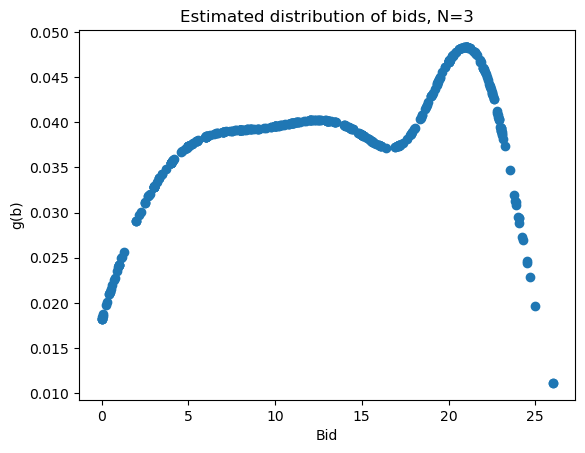

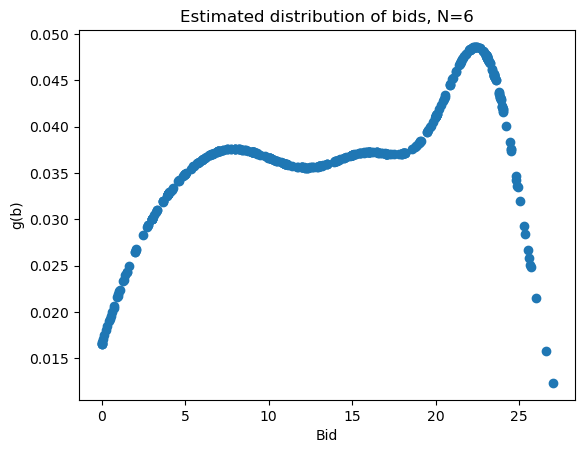

In [181]:
# Compute an estimate of g(b) for each bid in the data using Silverman's rule of thumb for the bandwidth
# and plot the results

# Estimate the distribution of the bids using the normal kernel
def estimate_g(bid_data, bandwidth):
    """Estimate the distribution of the bids using the normal kernel."""
    g = np.zeros(len(bid_data))
    for i in range(len(bid_data)):
        g[i] = np.mean(norm.pdf(bid_data, bid_data[i], bandwidth))
    return g

# Compute the bandwidths using Silverman's rule of thumb
# compute iqr 
iqr = np.percentile(data['BidC3'].values, 75) - np.percentile(data['BidC3'].values, 25)
h3 = 0.9 * np.min([np.std(data['BidC3'].values), iqr/1.34]) * len(data['BidC3'].values)**(-1/5)
# Compute the g(b) values
g3 = estimate_g(data['BidC3'].values, h3)
# Plot the results
plt.plot(data['BidC3'].values, g3, 'o')
plt.xlabel('Bid')
plt.ylabel('g(b)')
plt.title('Estimated distribution of bids, N=3')
plt.show()

# Compute the bandwidths
iqr = np.percentile(data['BidC6'].values, 75) - np.percentile(data['BidC6'].values, 25)
h6 = 0.9 * np.min([np.std(data['BidC6'].values), iqr/1.34]) * len(data['BidC6'].values)**(-1/5)
# Compute the g(b) values
g6 = estimate_g(data['BidC6'].values, h6)
# Plot the results
plt.plot(data['BidC6'].values, g6, 'o')
plt.xlabel('Bid')
plt.ylabel('g(b)')
plt.title('Estimated distribution of bids, N=6')
plt.show()

##### CDF Estimation 2 Ways: Within Experiment & Across Experiment #####

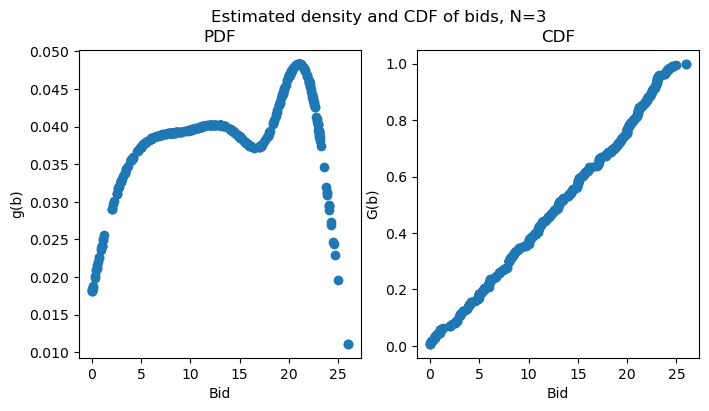

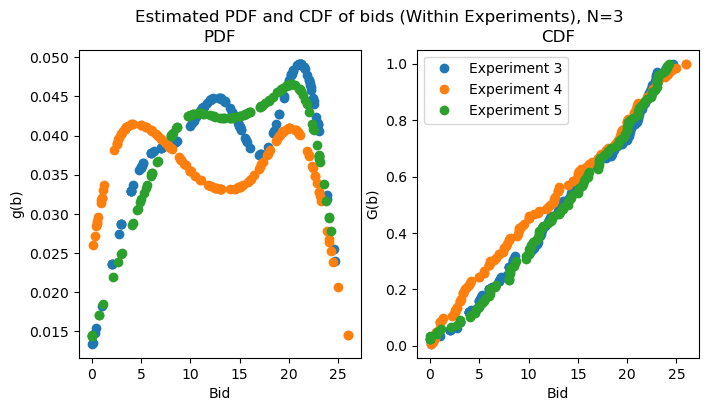

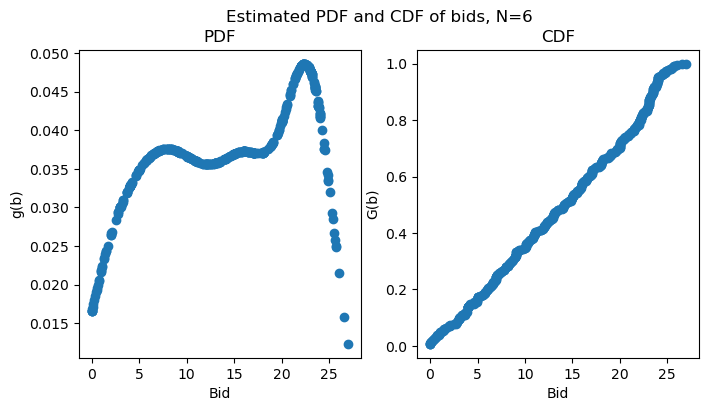

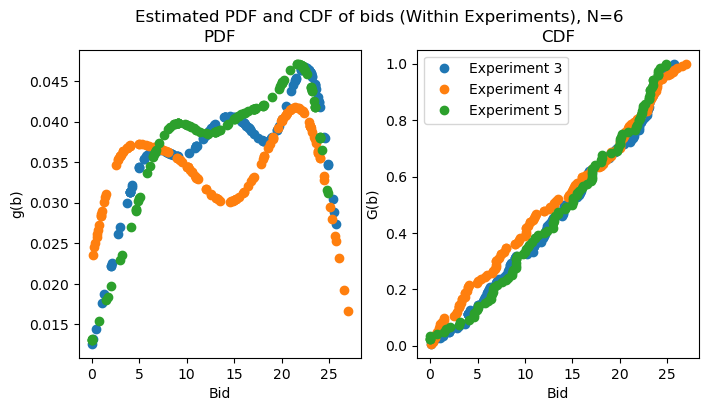

In [182]:
# N=3 case
# Estimate density and CDF of bids using data across experiments 4, 5, and 6
# Estimate the bandwidth
iqr = np.percentile(data['BidC3'].values, 75) - np.percentile(data['BidC3'].values, 25)
h3 = 0.9 * np.min([np.std(data['BidC3'].values), iqr/1.34]) * len(data['BidC3'].values)**(-1/5)
# Estimate the density
g3 = estimate_g(data['BidC3'].values, h3)
# Estimate the CDF
G3 = np.zeros(len(data['BidC3'].values))
for i in range(len(data['BidC3'].values)):
    G3[i] = np.mean(data['BidC3'].values <= data['BidC3'].values[i])
# Plot the results
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(data['BidC3'].values, g3, 'o', label='Density')
ax1.set_xlabel('Bid')
ax1.set_ylabel('g(b)')
ax1.set_title('PDF')
ax2.plot(data['BidC3'].values, G3, 'o', label='CDF')
ax2.set_xlabel('Bid')
ax2.set_ylabel('G(b)')
ax2.set_title('CDF')
fig.suptitle('Estimated density and CDF of bids, N=3')
plt.show()
# Save this result for later use
g_N3 = g3
G_N3 = G3

# Estimate density and CDF of bids using data within experiments 3, 4, and 5
g3dict = {}
G3dict = {}
for experiment in [3, 4, 5]:
    iqr = np.percentile(data[data['Experiment'] == experiment]['BidC3'].values, 75) - \
            np.percentile(data[data['Experiment'] == experiment]['BidC3'].values, 25)
    h3 = 0.9 * np.min([np.std(data[data['Experiment'] == experiment]['BidC3'].values), iqr/1.34]) * \
            len(data[data['Experiment'] == experiment]['BidC3'].values)**(-1/5)
    g3dict[experiment] = estimate_g(data[data['Experiment'] == experiment]['BidC3'].values, h3)
    G3 = np.zeros(len(data[data['Experiment'] == experiment]['BidC3'].values))
    for i in range(len(data[data['Experiment'] == experiment]['BidC3'].values)):
        G3[i] = np.mean(data[data['Experiment'] == experiment]['BidC3'].values <= \
                        data[data['Experiment'] == experiment]['BidC3'].values[i])
    G3dict[experiment] = G3
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plotx = np.concatenate([data[data['Experiment'] == 3]['BidC3'].values, \
                        data[data['Experiment'] == 4]['BidC3'].values, \
                        data[data['Experiment'] == 5]['BidC3'].values])
ax1.plot(data[data['Experiment'] == 3]['BidC3'].values, g3dict.get(3), 'o', label='Experiment 3')
ax1.plot(data[data['Experiment'] == 4]['BidC3'].values, g3dict.get(4), 'o', label='Experiment 4')
ax1.plot(data[data['Experiment'] == 5]['BidC3'].values, g3dict.get(5), 'o', label='Experiment 5')
ax1.set_xlabel('Bid')
ax1.set_ylabel('g(b)')
ax1.set_title('PDF')
ax2.plot(data[data['Experiment'] == 3]['BidC3'].values, G3dict.get(3), 'o', label='Experiment 3')
ax2.plot(data[data['Experiment'] == 4]['BidC3'].values, G3dict.get(4), 'o', label='Experiment 4')
ax2.plot(data[data['Experiment'] == 5]['BidC3'].values, G3dict.get(5), 'o', label='Experiment 5')
ax2.set_xlabel('Bid')
ax2.set_ylabel('G(b)')
ax2.set_title('CDF')
ax2.legend()
fig.suptitle('Estimated PDF and CDF of bids (Within Experiments), N=3')
plt.show()


# N=6 case
# Estimate density and CDF of bids using data across experiments 4, 5, and 6
# Estimate the bandwidth
iqr = np.percentile(data['BidC6'].values, 75) - np.percentile(data['BidC6'].values, 25)
h6 = 0.9 * np.min([np.std(data['BidC6'].values), iqr/1.34]) * len(data['BidC6'].values)**(-1/5)
# Estimate the density
g6 = estimate_g(data['BidC6'].values, h6)
# Estimate the CDF
G6 = np.zeros(len(data['BidC6'].values))
for i in range(len(data['BidC6'].values)):
    G6[i] = np.mean(data['BidC6'].values <= data['BidC6'].values[i])
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(data['BidC6'].values, g6, 'o', label='Density')
ax1.set_xlabel('Bid')
ax1.set_ylabel('g(b)')
ax1.set_title('PDF')
ax2.plot(data['BidC6'].values, G6, 'o', label='CDF')
ax2.set_xlabel('Bid')
ax2.set_ylabel('G(b)')
ax2.set_title('CDF')
fig.suptitle('Estimated PDF and CDF of bids, N=6')
plt.show()
# Save this result for later use
g_N6 = g6
G_N6 = G6

# Estimate density and CDF of bids using data within experiments 3, 4, and 5
g6dict = {}
G6dict = {}
for experiment in [3, 4, 5]:
    iqr = np.percentile(data[data['Experiment'] == experiment]['BidC6'].values, 75) - \
            np.percentile(data[data['Experiment'] == experiment]['BidC6'].values, 25)
    h6 = 0.9 * np.min([np.std(data[data['Experiment'] == experiment]['BidC6'].values), iqr/1.34]) * \
            len(data[data['Experiment'] == experiment]['BidC6'].values)**(-1/5)
    g6dict[experiment] = estimate_g(data[data['Experiment'] == experiment]['BidC6'].values, h6)
    G6 = np.zeros(len(data[data['Experiment'] == experiment]['BidC6'].values))
    for i in range(len(data[data['Experiment'] == experiment]['BidC6'].values)):
        G6[i] = np.mean(data[data['Experiment'] == experiment]['BidC6'].values <= \
                        data[data['Experiment'] == experiment]['BidC6'].values[i])
    G6dict[experiment] = G6
# Concatenate results across experiments
g6 = np.concatenate([g6dict[3], g6dict[4], g6dict[5]])
G6 = np.concatenate([G6dict[3], G6dict[4], G6dict[5]])
# Plot the results
plotx = np.concatenate([data[data['Experiment'] == 3]['BidC6'].values, \
                        data[data['Experiment'] == 4]['BidC6'].values, \
                        data[data['Experiment'] == 5]['BidC6'].values])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(data[data['Experiment'] == 3]['BidC6'].values, g6dict.get(3), 'o', label='Experiment 3')
ax1.plot(data[data['Experiment'] == 4]['BidC6'].values, g6dict.get(4), 'o', label='Experiment 4')
ax1.plot(data[data['Experiment'] == 5]['BidC6'].values, g6dict.get(5), 'o', label='Experiment 5')
ax1.set_xlabel('Bid')
ax1.set_ylabel('g(b)')
ax1.set_title('PDF')
ax2.plot(data[data['Experiment'] == 3]['BidC6'].values, G6dict.get(3), 'o', label='Experiment 3')
ax2.plot(data[data['Experiment'] == 4]['BidC6'].values, G6dict.get(4), 'o', label='Experiment 4')
ax2.plot(data[data['Experiment'] == 5]['BidC6'].values, G6dict.get(5), 'o', label='Experiment 5')
ax2.set_xlabel('Bid')
ax2.set_ylabel('G(b)')
ax2.set_title('CDF')
ax2.legend()
fig.suptitle('Estimated PDF and CDF of bids (Within Experiments), N=6')
plt.show()

##### True Valuation vs. Model Estimated Valuations #####

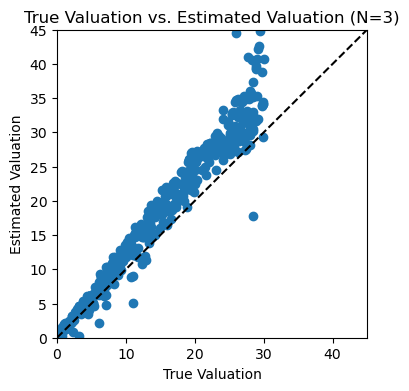

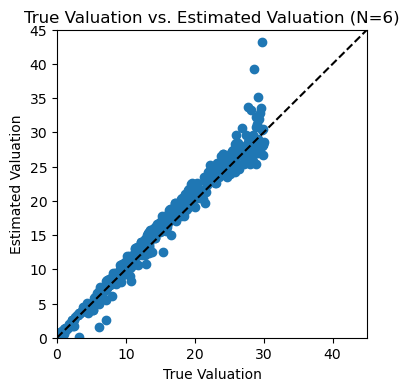

In [183]:
# Part (a)
# Use equation (9) and previous calculations to compute two estimates for each valuation (N=3 and N=6)
# N=3 case
def v_risk_neutral(b, g, G, N):
    return b + G/(g*(N-1))
v3 = np.zeros(len(data['BidC3'].values))
for i in range(len(data['BidC3'].values)):
    v3[i] = v_risk_neutral(data['BidC3'].values[i], g_N3[i], G_N3[i], 3)
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(data['Value'].values, v3)
ax.plot([0, 45], [0, 45], 'k--')
ax.set_xlim([0, 45])
ax.set_ylim([0, 45])
ax.set_xlabel('True Valuation')
ax.set_ylabel('Estimated Valuation')
ax.set_title('True Valuation vs. Estimated Valuation (N=3)')
plt.show()

# N=6 case
v6 = np.zeros(len(data['BidC6'].values))
for i in range(len(data['BidC6'].values)):
    v6[i] = v_risk_neutral(data['BidC6'].values[i], g_N6[i], G_N6[i], 6)
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(data['Value'].values, v6)
ax.plot([0, 45], [0, 45], 'k--')
ax.set_xlim([0, 45])
ax.set_ylim([0, 45])
ax.set_xlabel('True Valuation')
ax.set_ylabel('Estimated Valuation')
ax.set_title('True Valuation vs. Estimated Valuation (N=6)')
plt.show()


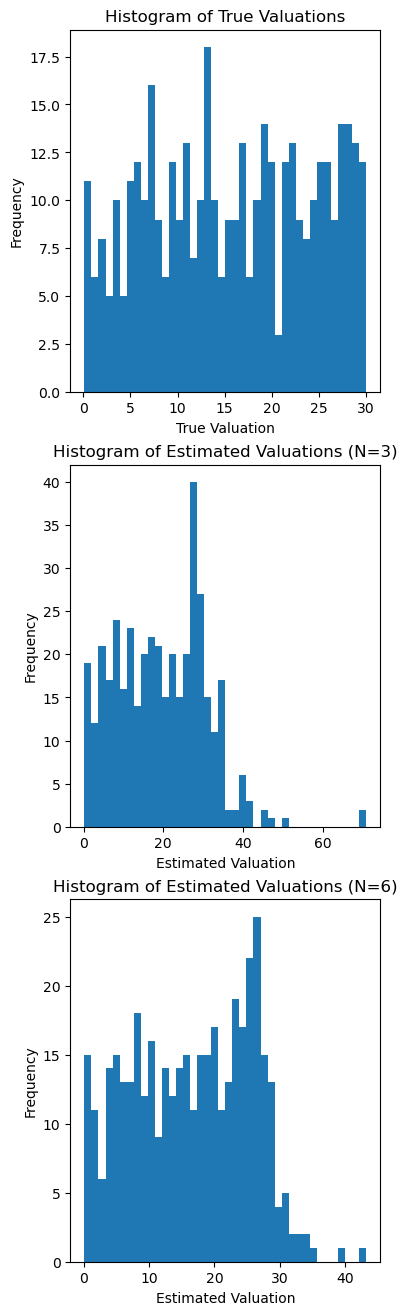

In [184]:
# Part (b)
# Plot histograms of true valuations and estimated valuations (N=3 and N=6)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4, 16))
ax1.hist(data['Value'].values, bins=40)
ax1.set_xlabel('True Valuation')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of True Valuations')
ax2.hist(v3, bins=40)
ax2.set_xlabel('Estimated Valuation')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Estimated Valuations (N=3)')
ax3.hist(v6, bins=40)
ax3.set_xlabel('Estimated Valuation')
ax3.set_ylabel('Frequency')
ax3.set_title('Histogram of Estimated Valuations (N=6)')
plt.show()

##### Computing Distance between Estimates and Truths #####

In [185]:
# Compute L1 and L2 distances for the two ways of estimating the CDF and PDF in CDF Estimation
# Across Experiment (N=6)
L1_across = np.zeros(len(data['Value'].values))
L2_across = np.zeros(len(data['Value'].values))
for i in range(len(data['Value'].values)):
    L1_across[i] = np.abs(data['Value'].values[i] - v6[i])
    L2_across[i] = (data['Value'].values[i] - v6[i])**2
L1_across = np.mean(L1_across)
L2_across = np.sqrt(np.mean(L2_across))
print('L1 distance (across experiment):', L1_across)
print('L2 distance (across experiment):', L2_across)
# Across Experiment (N=3)
L1_across = np.zeros(len(data['Value'].values))
L2_across = np.zeros(len(data['Value'].values))
for i in range(len(data['Value'].values)):
    L1_across[i] = np.abs(data['Value'].values[i] - v3[i])
    L2_across[i] = (data['Value'].values[i] - v3[i])**2
L1_across = np.mean(L1_across)
L2_across = np.sqrt(np.mean(L2_across))
print('L1 distance (across experiment):', L1_across)
print('L2 distance (across experiment):', L2_across)

L1 distance (across experiment): 1.1498789494094162
L2 distance (across experiment): 1.675483656671308
L1 distance (across experiment): 3.8603540756253176
L2 distance (across experiment): 5.492224258244711


### Risk Averse Structural Model for Valuation-Prediction ###

##### Computing Integer Percentiles of Bid Data #####

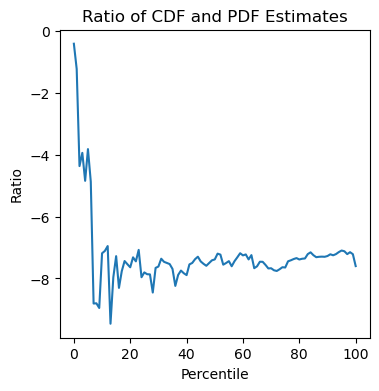

In [186]:
# Construct and store 0 through 100 integer percentiles of the bid data. 
# At each percentile, compute CDF and PDF estimates. 
# Use these esimates to compute G(b;N=6)/(5*g(b;N=6)) - G(b;N=3)/(2*g(b;N=3)) for each percentile.

# N=6
percentiles = np.linspace(0, 100, 101)
G6 = np.zeros(len(percentiles))
g6 = np.zeros(len(percentiles))
for i in range(len(percentiles)):
    G6[i] = np.percentile(data['BidC6'].values, percentiles[i])
    g6[i] = np.sum(data['BidC6'].values <= G6[i])/len(data['BidC6'].values)
# N=3
G3 = np.zeros(len(percentiles))
g3 = np.zeros(len(percentiles))
for i in range(len(percentiles)):
    G3[i] = np.percentile(data['BidC3'].values, percentiles[i])
    g3[i] = np.sum(data['BidC3'].values <= G3[i])/len(data['BidC3'].values)
# Compute the ratio
ratio = np.zeros(len(percentiles))
for i in range(len(percentiles)):
    ratio[i] = G6[i]/(5*g6[i]) - G3[i]/(2*g3[i])

# Plot the ratio
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(percentiles, ratio)
ax.set_xlabel('Percentile')
ax.set_ylabel('Ratio')
ax.set_title('Ratio of CDF and PDF Estimates')
plt.show()


##### Estimating Parameters of Linear Model #####

In [187]:
# Estimate theta = (b_{N=3} - b_{N=6})/ratio using OLS in three ways:
# (1) Using the full sample of percentiles
# (2) Using the percentiles 5 to 95
# (3) Using the percentiles 25 to 75
# Report point estimates and standard errors for each of the three estimates

# (1) Using the full sample of percentiles
X = np.ones((len(percentiles), 1))
X[:, 0] = ratio
y = G3 - G6
theta1 = np.linalg.inv(X.T @ X) @ X.T @ y
print('theta1:', theta1)
# (2) Using the percentiles 5 to 95
X = np.ones((len(percentiles)-10, 1))
X[:, 0] = ratio[5:-5]
y = G3[5:-5] - G6[5:-5]
theta2 = np.linalg.inv(X.T @ X) @ X.T @ y
print('theta2:', theta2)
# (3) Using the percentiles 25 to 75
X = np.ones((len(percentiles)-50, 1))
X[:, 0] = ratio[25:-25]
y = G3[25:-25] - G6[25:-25]
theta3 = np.linalg.inv(X.T @ X) @ X.T @ y
print('theta3:', theta3)

theta1: [0.11422194]
theta2: [0.11366252]
theta3: [0.11673834]


##### True Valuation vs. Model Estimated Valuations #####

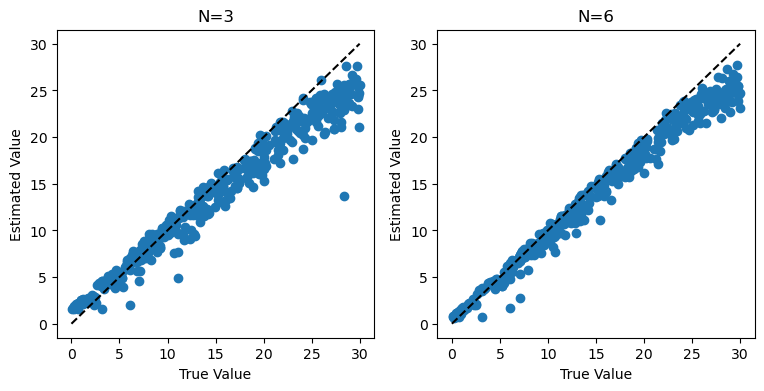

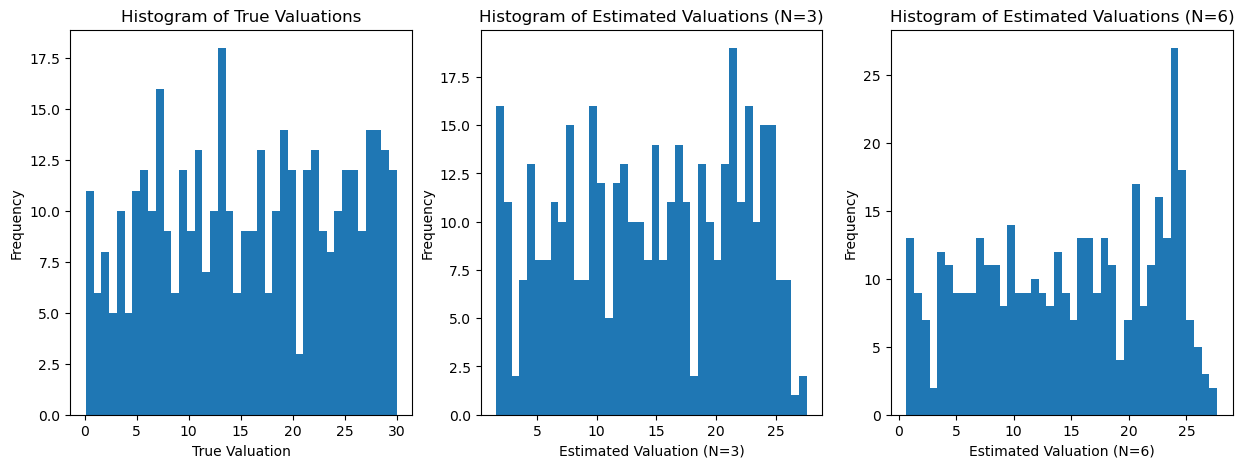

L1 distance (N=3): 1.8188910842957358
L2 distance (N=3): 2.4757687517537543
L1 distance (N=6): 1.4854413295904578
L2 distance (N=6): 2.042485947705061


In [188]:
# First stretch g3 g6 G3 G6 to the same length as data['Value'].values
g3_stretch = np.zeros(len(data['Value'].values))
g6_stretch = np.zeros(len(data['Value'].values))
G3_stretch = np.zeros(len(data['Value'].values))
G6_stretch = np.zeros(len(data['Value'].values))
for i in range(len(data['Value'].values)):
    g3_stretch[i] = g3[i//10]
    g6_stretch[i] = g6[i//10]
    G3_stretch[i] = G3[i//10]
    G6_stretch[i] = G6[i//10]
g3, g6, G3, G6 = g3_stretch, g6_stretch, G3_stretch, G6_stretch

# Compute estimates of the true value for N=3 and N=6 using theta3
def v_risk_averse(b, g, G, N, theta):
    return b + theta*(G/(g*(N-1)))
v3_risk_averse = np.zeros(len(data['BidC3'].values))
v6_risk_averse = np.zeros(len(data['BidC3'].values))
for i in range(len(data['BidC3'].values)):
    v3_risk_averse[i] = v_risk_averse(data['BidC3'].values[i], g3[i], G3[i], 3, theta3)
    v6_risk_averse[i] = v_risk_averse(data['BidC6'].values[i], g6[i], G6[i], 6, theta3)

# Also draw a scatter plot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].scatter(data['Value'].values, v3_risk_averse)
ax[0].plot([0, 30], [0, 30], 'k--')
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Estimated Value')
ax[0].set_title('N=3')
ax[1].scatter(data['Value'].values, v6_risk_averse)
ax[1].plot([0, 30], [0, 30], 'k--')
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Estimated Value')
ax[1].set_title('N=6')
plt.show()

# Plot histograms of the true valuations and the estimated valuations for N=3 and N=6
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hist(data['Value'].values, bins=40)
ax1.set_xlabel('True Valuation')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of True Valuations')
ax2.hist(v3_risk_averse, bins=40)
ax2.set_xlabel('Estimated Valuation (N=3)')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Estimated Valuations (N=3)')
ax3.hist(v6_risk_averse, bins=40)
ax3.set_xlabel('Estimated Valuation (N=6)')
ax3.set_ylabel('Frequency')
ax3.set_title('Histogram of Estimated Valuations (N=6)')
plt.show()

# Compute L1 and L2 distances between the true valuations and the estimated valuations for N=3 and N=6
L1 = np.zeros(len(data['Value'].values))
L2 = np.zeros(len(data['Value'].values))
for i in range(len(data['Value'].values)):
    L1[i] = np.abs(data['Value'].values[i] - v3_risk_averse[i])
    L2[i] = (data['Value'].values[i] - v3_risk_averse[i])**2
L1 = np.mean(L1)
L2 = np.sqrt(np.mean(L2))
print('L1 distance (N=3):', L1)
print('L2 distance (N=3):', L2)
L1 = np.zeros(len(data['Value'].values))
L2 = np.zeros(len(data['Value'].values))
for i in range(len(data['Value'].values)):
    L1[i] = np.abs(data['Value'].values[i] - v6_risk_averse[i])
    L2[i] = (data['Value'].values[i] - v6_risk_averse[i])**2
L1 = np.mean(L1)
L2 = np.sqrt(np.mean(L2))
print('L1 distance (N=6):', L1)
print('L2 distance (N=6):', L2)

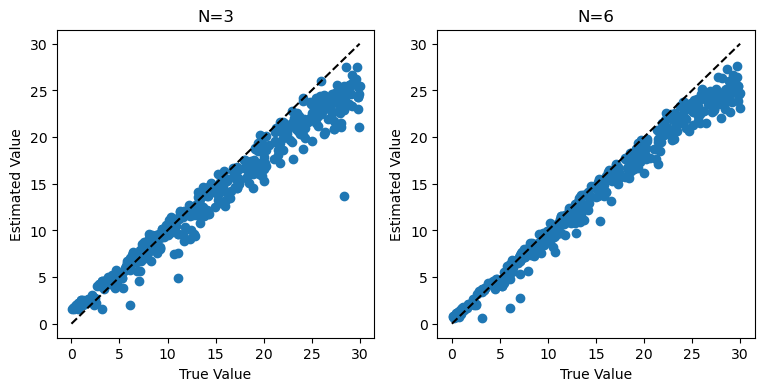

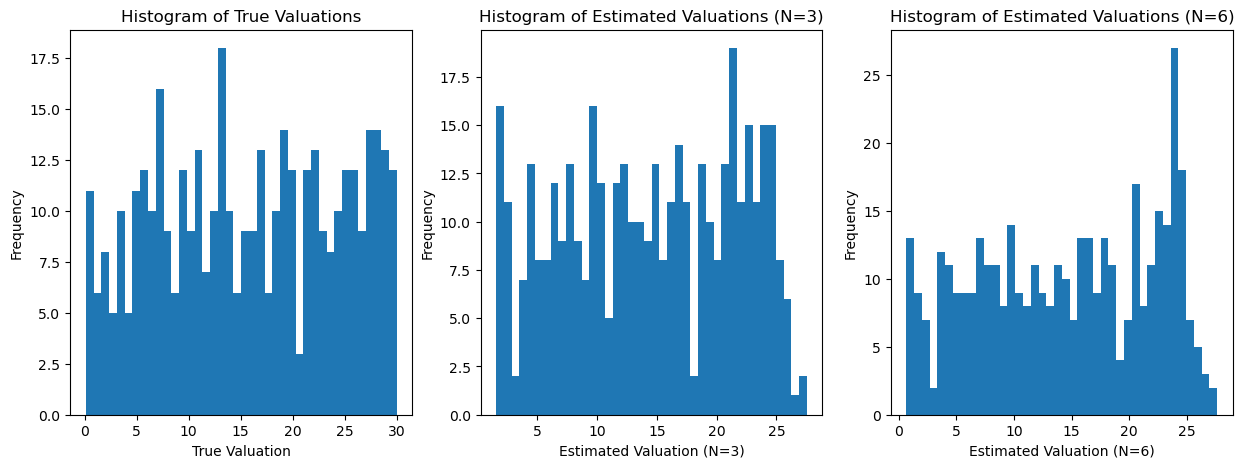

L1 distance (N=3): 1.8344837133706948
L2 distance (N=3): 2.495590283569006
L1 distance (N=6): 1.494878520919001
L2 distance (N=6): 2.0532185511334604


In [189]:
# Now we do the same for theta2
v3_risk_averse = np.zeros(len(data['BidC3'].values))
v6_risk_averse = np.zeros(len(data['BidC3'].values))
for i in range(len(data['BidC3'].values)):
    v3_risk_averse[i] = v_risk_averse(data['BidC3'].values[i], g3[i], G3[i], 3, theta2)
    v6_risk_averse[i] = v_risk_averse(data['BidC6'].values[i], g6[i], G6[i], 6, theta2)

# Also draw a scatter plot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].scatter(data['Value'].values, v3_risk_averse)
ax[0].plot([0, 30], [0, 30], 'k--')
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Estimated Value')
ax[0].set_title('N=3')
ax[1].scatter(data['Value'].values, v6_risk_averse)
ax[1].plot([0, 30], [0, 30], 'k--')
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Estimated Value')
ax[1].set_title('N=6')
plt.show()

# Plot histograms of the true valuations and the estimated valuations for N=3 and N=6
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hist(data['Value'].values, bins=40)
ax1.set_xlabel('True Valuation')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of True Valuations')
ax2.hist(v3_risk_averse, bins=40)
ax2.set_xlabel('Estimated Valuation (N=3)')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Estimated Valuations (N=3)')
ax3.hist(v6_risk_averse, bins=40)
ax3.set_xlabel('Estimated Valuation (N=6)')
ax3.set_ylabel('Frequency')
ax3.set_title('Histogram of Estimated Valuations (N=6)')
plt.show()

# Compute L1 and L2 distances between the true valuations and the estimated valuations for N=3 and N=6
L1 = np.zeros(len(data['Value'].values))
L2 = np.zeros(len(data['Value'].values))
for i in range(len(data['Value'].values)):
    L1[i] = np.abs(data['Value'].values[i] - v3_risk_averse[i])
    L2[i] = (data['Value'].values[i] - v3_risk_averse[i])**2
L1 = np.mean(L1)
L2 = np.sqrt(np.mean(L2))
print('L1 distance (N=3):', L1)
print('L2 distance (N=3):', L2)
L1 = np.zeros(len(data['Value'].values))
L2 = np.zeros(len(data['Value'].values))
for i in range(len(data['Value'].values)):
    L1[i] = np.abs(data['Value'].values[i] - v6_risk_averse[i])
    L2[i] = (data['Value'].values[i] - v6_risk_averse[i])**2
L1 = np.mean(L1)
L2 = np.sqrt(np.mean(L2))
print('L1 distance (N=6):', L1)
print('L2 distance (N=6):', L2)

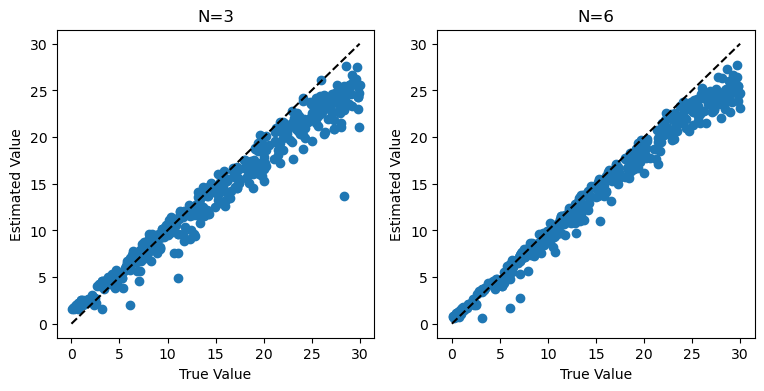

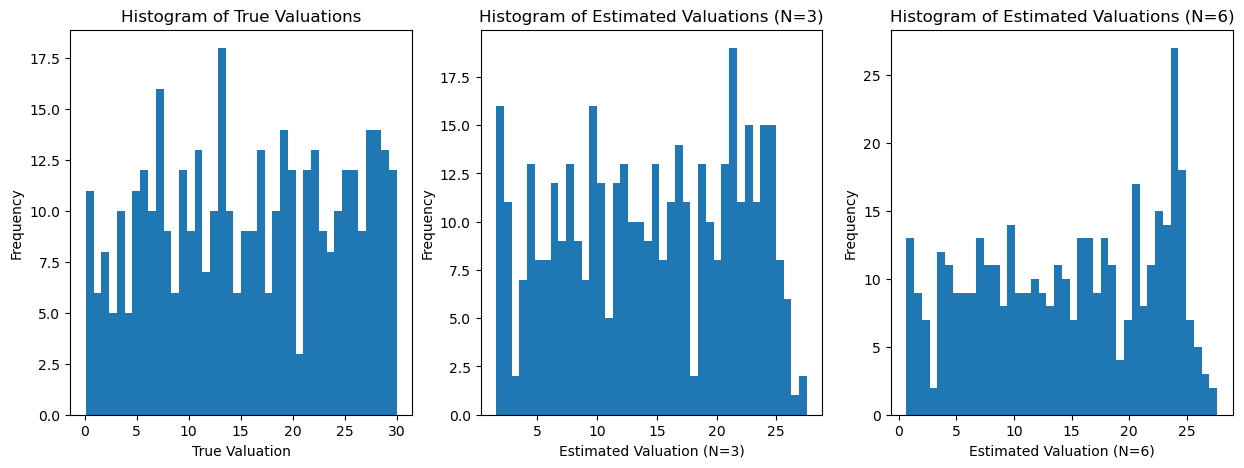

L1 distance (N=3): 1.8316417292893707
L2 distance (N=3): 2.491949955501836
L1 distance (N=6): 1.4931505891529544
L2 distance (N=6): 2.051259835598088


In [190]:
# And now theta1
v3_risk_averse = np.zeros(len(data['BidC3'].values))
v6_risk_averse = np.zeros(len(data['BidC3'].values))
for i in range(len(data['BidC3'].values)):
    v3_risk_averse[i] = v_risk_averse(data['BidC3'].values[i], g3[i], G3[i], 3, theta1)
    v6_risk_averse[i] = v_risk_averse(data['BidC6'].values[i], g6[i], G6[i], 6, theta1)

# Also draw a scatter plot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].scatter(data['Value'].values, v3_risk_averse)
ax[0].plot([0, 30], [0, 30], 'k--')
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Estimated Value')
ax[0].set_title('N=3')
ax[1].scatter(data['Value'].values, v6_risk_averse)
ax[1].plot([0, 30], [0, 30], 'k--')
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Estimated Value')
ax[1].set_title('N=6')
plt.show()

# Plot histograms of the true valuations and the estimated valuations for N=3 and N=6
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hist(data['Value'].values, bins=40)
ax1.set_xlabel('True Valuation')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of True Valuations')
ax2.hist(v3_risk_averse, bins=40)
ax2.set_xlabel('Estimated Valuation (N=3)')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Estimated Valuations (N=3)')
ax3.hist(v6_risk_averse, bins=40)
ax3.set_xlabel('Estimated Valuation (N=6)')
ax3.set_ylabel('Frequency')
ax3.set_title('Histogram of Estimated Valuations (N=6)')
plt.show()

# Compute L1 and L2 distances between the true valuations and the estimated valuations for N=3 and N=6
L1 = np.zeros(len(data['Value'].values))
L2 = np.zeros(len(data['Value'].values))
for i in range(len(data['Value'].values)):
    L1[i] = np.abs(data['Value'].values[i] - v3_risk_averse[i])
    L2[i] = (data['Value'].values[i] - v3_risk_averse[i])**2
L1 = np.mean(L1)
L2 = np.sqrt(np.mean(L2))
print('L1 distance (N=3):', L1)
print('L2 distance (N=3):', L2)
L1 = np.zeros(len(data['Value'].values))
L2 = np.zeros(len(data['Value'].values))
for i in range(len(data['Value'].values)):
    L1[i] = np.abs(data['Value'].values[i] - v6_risk_averse[i])
    L2[i] = (data['Value'].values[i] - v6_risk_averse[i])**2
L1 = np.mean(L1)
L2 = np.sqrt(np.mean(L2))
print('L1 distance (N=6):', L1)
print('L2 distance (N=6):', L2)